In [4]:
!pip install torch_geometric
import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, InstanceNorm, GATConv
import torch.nn.functional as F
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:0000:0100:01


In [5]:
train = np.load('/kaggle/input/d/sarthaksachdev1108/gcn-data/embed_outputs_train.npy')
test = np.load('/kaggle/input/d/sarthaksachdev1108/gcn-data/embed_outputs_test.npy')
adj_matrix = np.load('/kaggle/input/d/sarthaksachdev1108/gcn-data/adj_matrix.npy')
labels = np.load('/kaggle/input/d/sarthaksachdev1108/gcn-data/labels.npy')

In [6]:
temp = []
for x in adj_matrix:
    temp.append(x)
mn = np.mean(temp)
adj_matrix[adj_matrix < mn] = 0

In [7]:
len(labels), train.shape, test.shape, adj_matrix.shape

(885, (708, 8, 32), (177, 8, 32), (885, 885))

In [8]:
train_mask = [True]*708 + [False]*177
test_mask = [False]*708 + [True]*177
train_mask = np.array(train_mask)
test_mask = np.array(test_mask)

In [9]:
features = torch.from_numpy(np.concatenate((train, test), axis=0)).float()
labels = torch.from_numpy(labels).float()
edge_index = torch.from_numpy(np.argwhere(adj_matrix != 0).T).long()
data = Data(x=features, edge_index=edge_index, y=labels)
data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

Epoch: 100, Loss: 0.001346, Acc: 0.7345
Epoch: 200, Loss: 0.001242, Acc: 0.7740
Epoch: 300, Loss: 0.001175, Acc: 0.7458
Epoch: 400, Loss: 0.001144, Acc: 0.7797
Epoch: 500, Loss: 0.001131, Acc: 0.8136
Epoch: 600, Loss: 0.001090, Acc: 0.7627
Epoch: 700, Loss: 0.001075, Acc: 0.7514
Epoch: 800, Loss: 0.001069, Acc: 0.7910
Epoch: 900, Loss: 0.001075, Acc: 0.7797
Epoch: 1000, Loss: 0.000990, Acc: 0.8079
Epoch: 1100, Loss: 0.000976, Acc: 0.8249
Epoch: 1200, Loss: 0.000997, Acc: 0.8136
Epoch: 1300, Loss: 0.000966, Acc: 0.8136
Epoch: 1400, Loss: 0.000989, Acc: 0.8023
Epoch: 1500, Loss: 0.000988, Acc: 0.8079
Epoch: 1600, Loss: 0.000950, Acc: 0.8475
Epoch: 1700, Loss: 0.000921, Acc: 0.7966
Epoch: 1800, Loss: 0.001027, Acc: 0.8023
Epoch: 1900, Loss: 0.000885, Acc: 0.8305
Epoch: 2000, Loss: 0.000949, Acc: 0.8362
Epoch: 2100, Loss: 0.000883, Acc: 0.8079
Epoch: 2200, Loss: 0.000927, Acc: 0.8305
Epoch: 2300, Loss: 0.000859, Acc: 0.7910
Epoch: 2400, Loss: 0.000880, Acc: 0.8136
Epoch: 2500, Loss: 0.0008

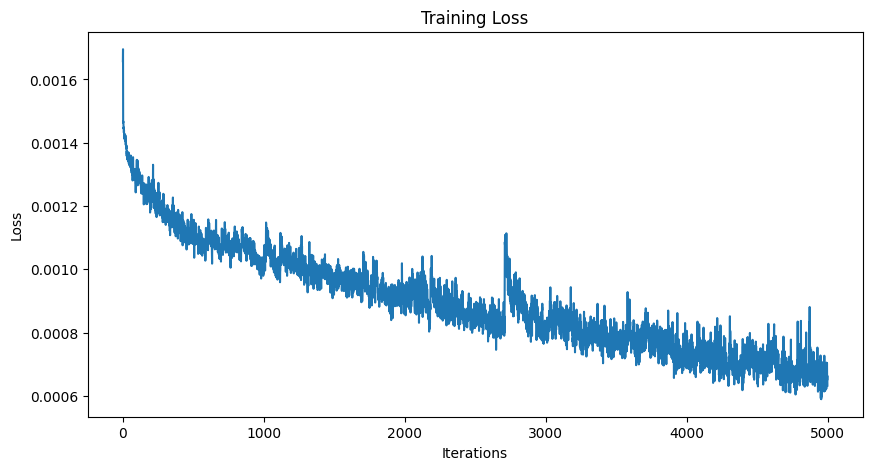

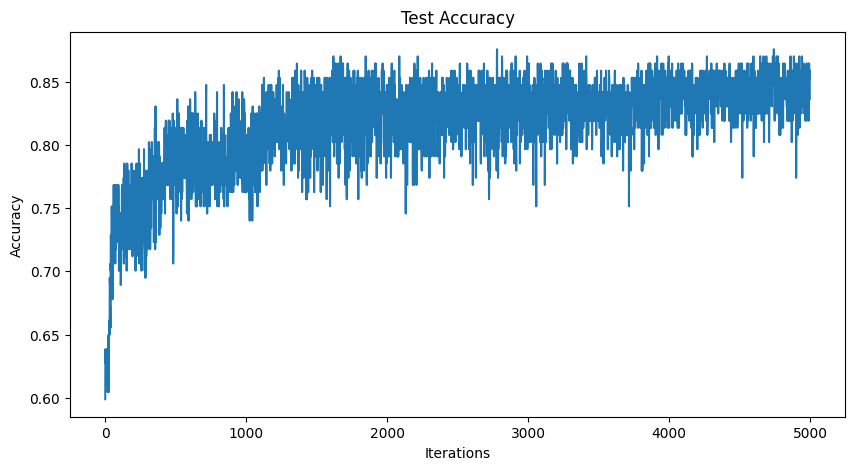

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1d = torch.nn.Conv2d(1, 16, (3, 3))
        self.conv1 = GCNConv(6*16*30, 512)
        self.conv2 = GCNConv(512, 128)
        self.norm1 = InstanceNorm(512)  
        self.norm2 = InstanceNorm(128)  
        self.out = torch.nn.Linear(128, 1)
        self.dropout = torch.nn.Dropout(0.2) 
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.view(-1, 1, 8, 32)  
        x = F.relu(self.conv1d(x))
        x = x.view(data.num_nodes, -1)
        x = F.relu(self.conv1(x, edge_index))
        x = self.norm1(x)  
        x = self.dropout(x) 
        x = F.relu(self.conv2(x, edge_index))
        x = self.norm2(x) 
        x = self.dropout(x) 
        x = self.out(x)
        x = torch.sigmoid(x)
        return x.squeeze(1)

model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

arr = []
for i in range(708):
    if labels[i]==1:
        arr.append(1/len(labels[labels==1]))
    elif labels[i]==0:
        arr.append(1/len(labels[labels==0]))
weights = torch.tensor(arr).to(device)
criterion = torch.nn.BCELoss(weight=weights)

def train(data):
    model.train()
    optimizer.zero_grad()
    data = data.to(device) 
    out = model(data)[data.train_mask]
    loss = criterion(out, data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(data):
    model.eval()
    with torch.no_grad():
        data = data.to(device) 
        pred = model(data).round()[data.test_mask]
        correct = pred.eq(data.y[data.test_mask]).sum().item()
        acc = correct / data.test_mask.sum().item()
    return acc, pred

max_acc = 0
max_f1 = 0
best_epoch=0
losses=[]
accs=[]
true_labels = data.y[data.test_mask].cpu().numpy()
for epoch in range(1,5001):
    loss = train(data)
    acc,pred = test(data)
    losses.append(loss)
    accs.append(acc)
    predictions = pred.cpu().numpy()
    f1 = f1_score(true_labels, predictions)
    if f1 > max_f1:
        max_acc = acc
        best_epoch=epoch
        max_f1=f1
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Acc: {acc:.4f}')
        
print("Lessgooooo   ",max_acc)
print(best_epoch)
print(f"F1 Score: {max_f1:.4f}")

fig,ax = plt.subplots(figsize=(10,5))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

fig,ax = plt.subplots(figsize=(10,5))
plt.plot(accs)
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.show()

In [15]:
train = np.load('/kaggle/input/d/sarthaksachdev1108/gcn-data/aug_embed_outputs_train.npy')
test = np.load('/kaggle/input/d/sarthaksachdev1108/gcn-data/aug_embed_outputs_test.npy')
all_features = np.concatenate((train, test), axis=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = Data(x=features, edge_index=edge_index, y=labels).to(device)
data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

if not isinstance(train_mask, torch.Tensor):
    full_train_mask = torch.tensor(train_mask, dtype=torch.bool)
else:
    full_train_mask = train_mask.clone().detach()

if not isinstance(test_mask, torch.Tensor):
    full_test_mask = torch.tensor(test_mask, dtype=torch.bool)
else:
    full_test_mask = test_mask.clone().detach()

Epoch: 100, Loss: 0.001286, Acc: 0.7910
Epoch: 200, Loss: 0.001225, Acc: 0.7853
Epoch: 300, Loss: 0.001210, Acc: 0.7458
Epoch: 400, Loss: 0.001148, Acc: 0.7684
Epoch: 500, Loss: 0.001176, Acc: 0.7345
Epoch: 600, Loss: 0.001102, Acc: 0.7627
Epoch: 700, Loss: 0.001105, Acc: 0.7458
Epoch: 800, Loss: 0.001139, Acc: 0.7797
Epoch: 900, Loss: 0.001117, Acc: 0.7684
Epoch: 1000, Loss: 0.001147, Acc: 0.7288
Epoch: 1100, Loss: 0.001056, Acc: 0.8023
Epoch: 1200, Loss: 0.001084, Acc: 0.8023
Epoch: 1300, Loss: 0.001014, Acc: 0.8079
Epoch: 1400, Loss: 0.001012, Acc: 0.8418
Epoch: 1500, Loss: 0.001065, Acc: 0.8136
Epoch: 1600, Loss: 0.000968, Acc: 0.8249
Epoch: 1700, Loss: 0.000995, Acc: 0.8023
Epoch: 1800, Loss: 0.001027, Acc: 0.8192
Epoch: 1900, Loss: 0.000938, Acc: 0.8136
Epoch: 2000, Loss: 0.000965, Acc: 0.8644
Epoch: 2100, Loss: 0.000974, Acc: 0.8418
Epoch: 2200, Loss: 0.000937, Acc: 0.8531
Epoch: 2300, Loss: 0.000977, Acc: 0.8475
Epoch: 2400, Loss: 0.000940, Acc: 0.8475
Epoch: 2500, Loss: 0.0009

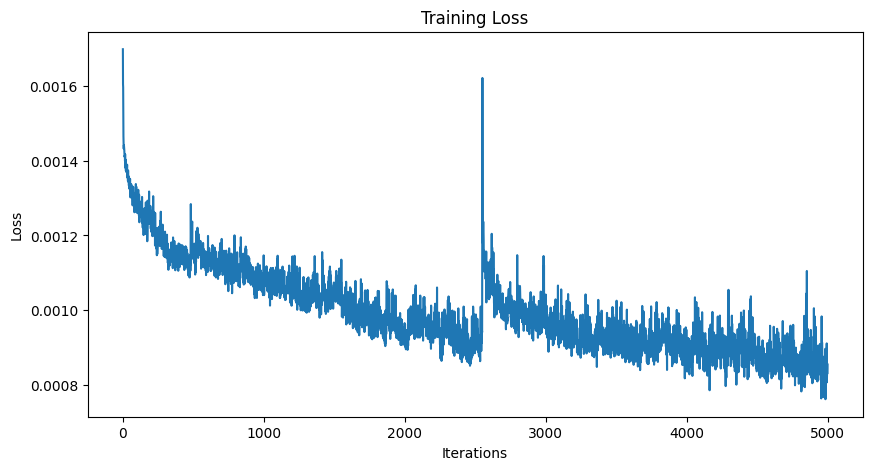

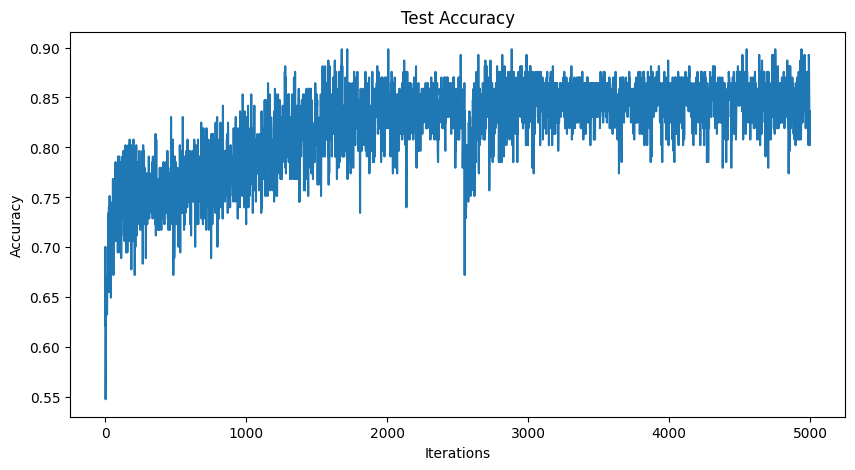

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1d = torch.nn.Conv2d(1, 16, (3, 3))
        self.conv1 = GCNConv(6*16*30, 512)
        self.conv2 = GCNConv(512, 128)
        self.norm1 = InstanceNorm(512)  
        self.norm2 = InstanceNorm(128)  
        self.out = torch.nn.Linear(128, 1)
        self.dropout = torch.nn.Dropout(0.2) 
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.view(-1, 1, 8, 32)  
        x = F.relu(self.conv1d(x))
        x = x.view(data.num_nodes, -1)
        x = F.relu(self.conv1(x, edge_index))
        x = self.norm1(x)  
        x = self.dropout(x) 
        x = F.relu(self.conv2(x, edge_index))
        x = self.norm2(x) 
        x = self.dropout(x) 
        x = self.out(x)
        x = torch.sigmoid(x)
        return x.squeeze(1)

model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

arr = []
for i in range(708):
    if labels[i]==1:
        arr.append(1/len(labels[labels==1]))
    elif labels[i]==0:
        arr.append(1/len(labels[labels==0]))
weights = torch.tensor(arr).to(device)
criterion = torch.nn.BCELoss(weight=weights)

def train(data):
    model.train()
    optimizer.zero_grad()
    data = data.to(device) 
    out = model(data)[data.train_mask]
    loss = criterion(out, data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(data):
    model.eval()
    with torch.no_grad():
        data = data.to(device) 
        pred = model(data).round()[data.test_mask]
        correct = pred.eq(data.y[data.test_mask]).sum().item()
        acc = correct / data.test_mask.sum().item()
    return acc, pred

max_acc = 0
max_f1 = 0
best_epoch=0
losses=[]
accs=[]
preds=None
true_labels = data.y[data.test_mask].cpu().numpy()
for epoch in range(1,5001):
    loss = train(data)
    acc,pred = test(data)
    losses.append(loss)
    accs.append(acc)
    predictions = pred.cpu().numpy()
    f1 = f1_score(true_labels, predictions)
    if f1 > max_f1:
        max_acc = acc
        best_epoch=epoch
        max_f1=f1
        predictions = preds
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Acc: {acc:.4f}')
        
print("Lessgooooo   ",max_acc)
print(best_epoch)
print(f"F1 Score: {max_f1:.4f}")

fig,ax = plt.subplots(figsize=(10,5))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

fig,ax = plt.subplots(figsize=(10,5))
plt.plot(accs)
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.show()

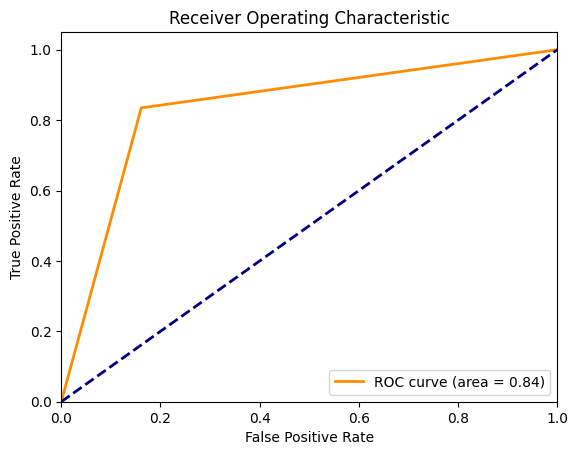

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

predictions = np.array(predictions)
true_labels = np.array(true_labels)
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()